The goal of this notebook is to calibrate the diffusion denoiser on a new dataset, then run a low-dim embedding on the denoised data, do a UMAP, then clustering. Grab those clusters and use as the basis for a synthetic dataset for the pairwise problem.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scanpy as sc

from sklearn.neighbors import NearestNeighbors
from sklearn.utils.extmath import randomized_svd

from sklearn.metrics import mean_squared_error

from molecular_cross_validation import util as ut
from molecular_cross_validation.mcv_sweep import GridSearchMCV
from molecular_cross_validation.scripts.diffusion_sweep import compute_diff_op

# Standard Workflow

In [2]:
def load_pbmc():
    adata = sc.read_10x_h5('/Users/josh/Downloads/5k_pbmc_v3_filtered_feature_bc_matrix.h5')
    adata.var_names_make_unique()
    sc.pp.filter_cells(adata, min_counts=1000)
    sc.pp.filter_genes(adata, min_cells=20)
    adata.X = np.array(adata.X.todense())
    return adata

In [3]:
def load_kidney():
    adata = sc.read('/Users/josh/src/molecular-cross-validation/data/tabula-muris-senis/tabula-muris-senis-droplet-processed-official-annotations-Kidney.h5ad')
    adata = sc.AnnData(X = adata.raw.X, obs = adata.obs)
    adata.X = np.array(adata.X.todense())
    return adata

In [22]:
def load_citeseq():
    adata = sc.read('/Users/josh/src/molecular-cross-validation/data/citeseq/bm.cite.h5ad')
    adata = sc.AnnData(X = adata.raw.X, obs = adata.obs)
    adata.X = np.array(adata.X.todense())
    return adata

In [4]:
kidney = load_kidney()

In [5]:
adata = kidney.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=None, min_disp=0.5)

highly_variable_genes = adata.var.highly_variable

adata = adata[:, adata.var.highly_variable]

In [6]:
sc.pp.scale(adata, max_value=10, zero_center=False)

/Users/josh/src/scanpy/scanpy/preprocessing/_simple.py:870: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
sc.tl.pca(adata, n_comps=100, zero_center=False, random_state = 1)

In [8]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 20]

Number of PCs matters for the UMAP

In [9]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/n2s/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/n2s/lib/pytho

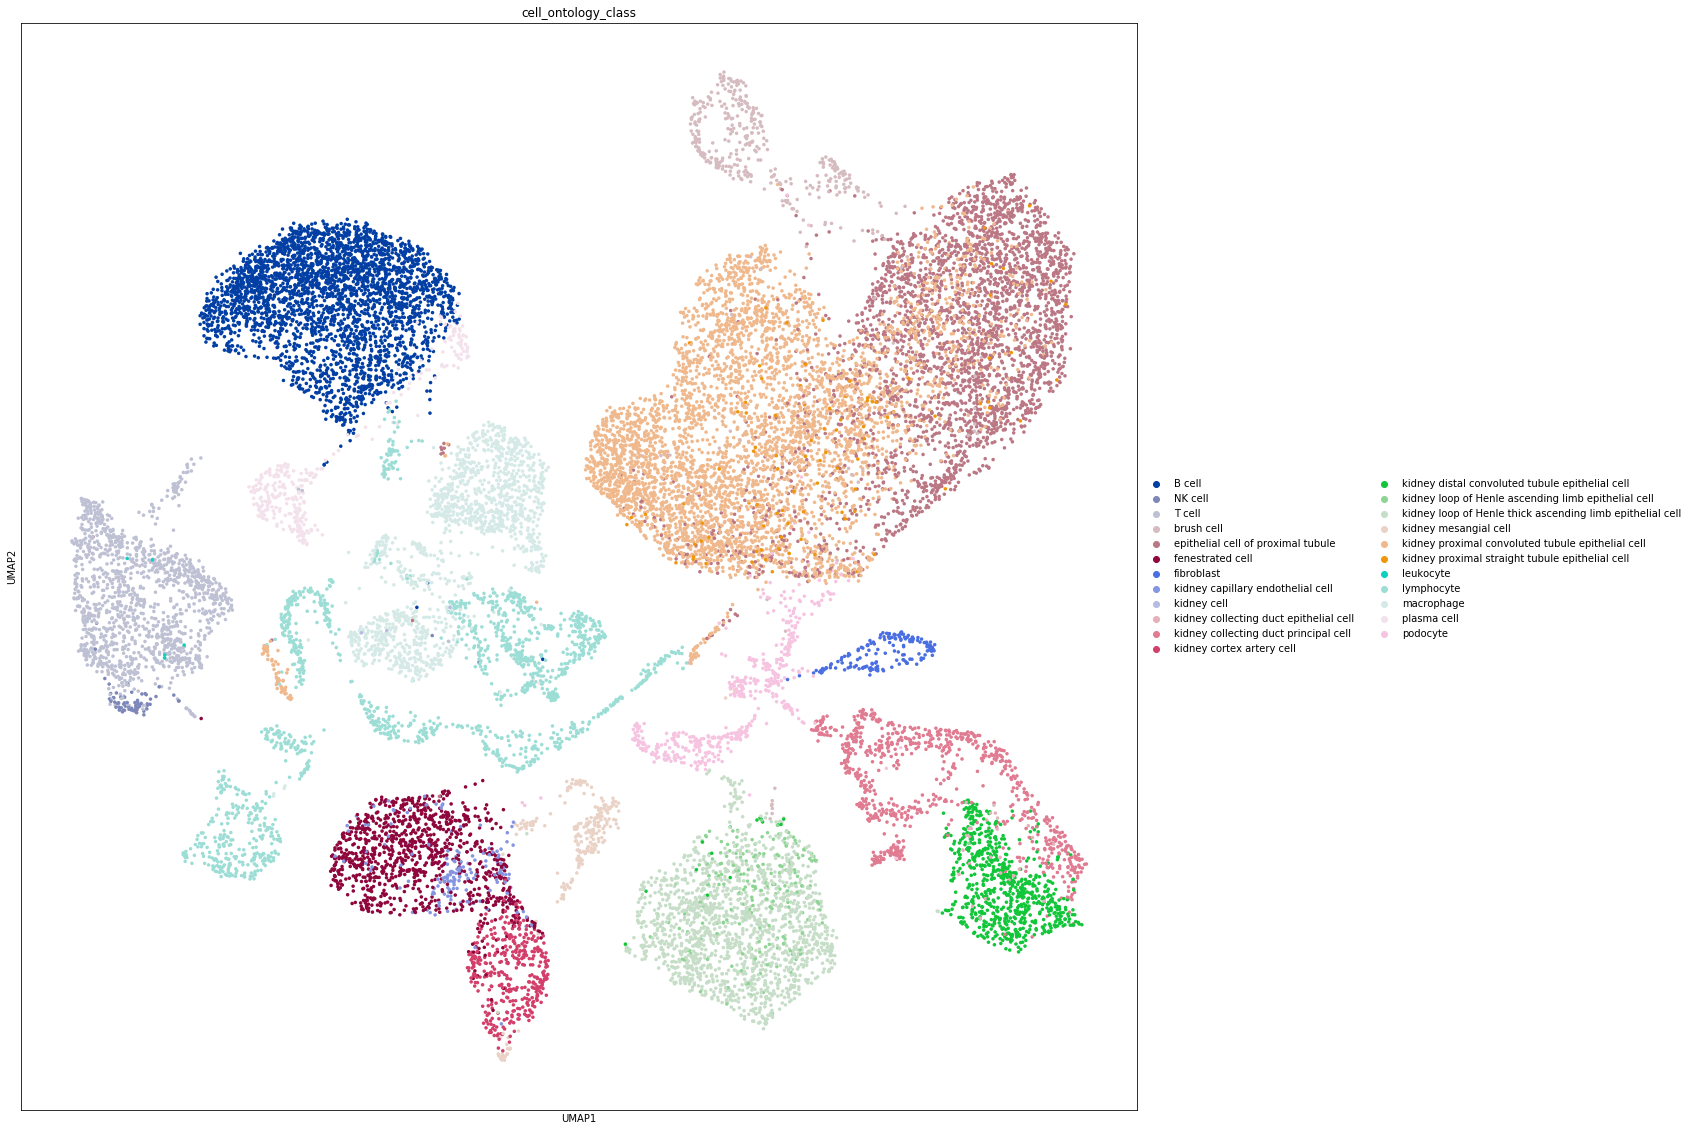

In [10]:
sc.pl.umap(adata, color='cell_ontology_class', size=50)

In [11]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=70)
sc.tl.umap(adata)

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/n2s/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


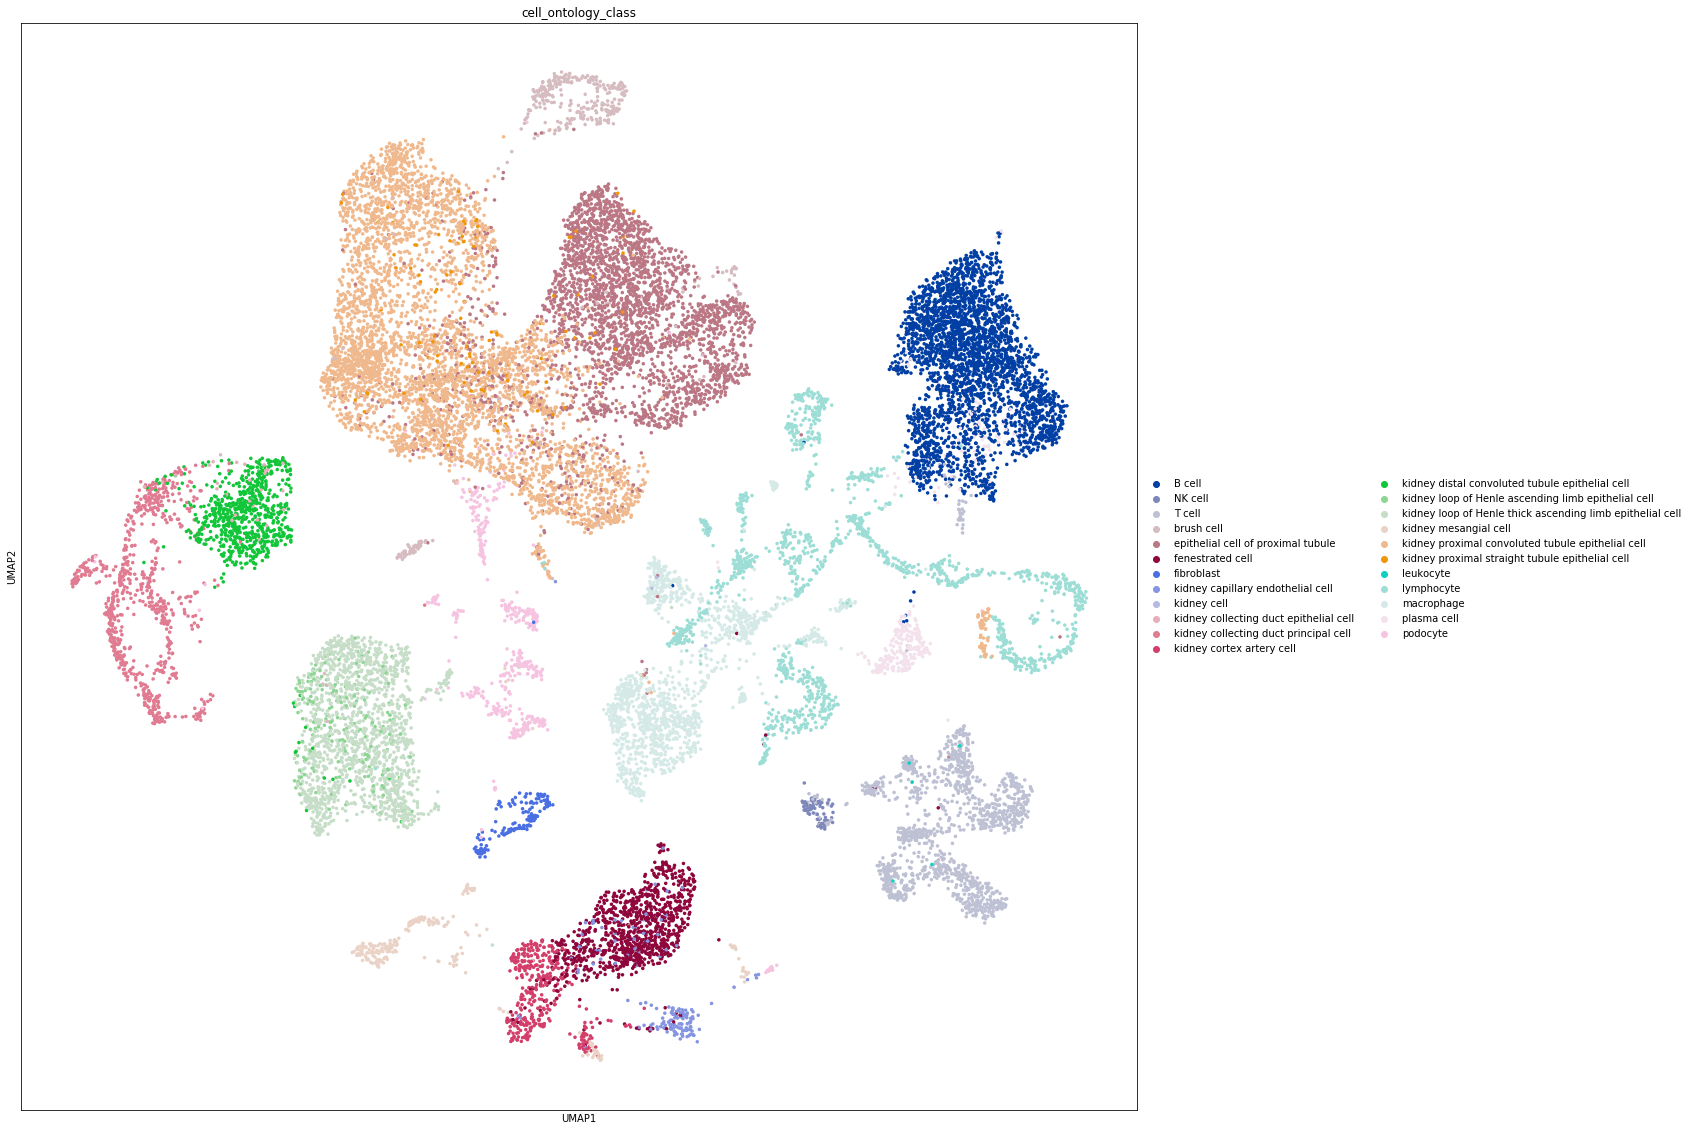

In [12]:
sc.pl.umap(adata, color='cell_ontology_class', size=50)

# MCV for PCA

Given a normalization scheme, do a 50-50 split for MCV.

In [13]:
def recipe_seurat(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10, zero_center=False)
    return adata

def recipe_sqrt(adata):
    sc.pp.sqrt(adata)
    return adata

def recipe_log(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    return adata

def mcv_pca(adata, recipe, max_pcs = 30):
    assert adata.X.dtype == np.int
    
    from scipy.sparse import issparse
    assert not issparse(adata.X)
    
    adata1 = adata.copy()
    adata2 = adata.copy()
    adata1.X = np.random.binomial(adata.X, 0.5).astype(np.float)
    adata2.X = adata.X - adata1.X
    
    adata1 = recipe(adata1)
    adata2 = recipe(adata2)
    
    sc.tl.pca(adata1, n_comps=max_pcs, zero_center=False, random_state = 1)
    
    k_range = np.arange(2, max_pcs, 2)
    mcv_loss = np.zeros(len(k_range))
    rec_loss = np.zeros(len(k_range))
        
    for i, k in enumerate(k_range):
        reconstruction = adata1.obsm['X_pca'][:,:k].dot(adata1.varm['PCs'].T[:k])
        mcv_loss[i] = mean_squared_error(reconstruction, adata2.X)
        rec_loss[i] = mean_squared_error(reconstruction, adata1.X)
    
    return k_range, mcv_loss, rec_loss

In [14]:
adata = kidney[:,highly_variable_genes].copy()
adata.X = np.array(adata.X.copy()).astype(np.int)

In [15]:
matplotlib.rcParams['figure.figsize'] = [6.4, 4.8]

Text(0.5, 1.0, 'MCV for Seurat Normalization')

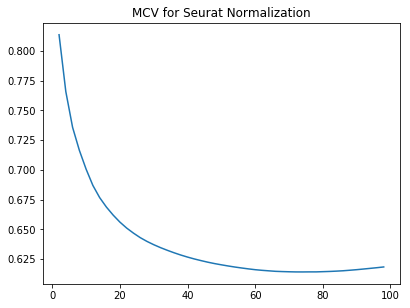

In [16]:
k_range, mcv_loss, rec_loss = mcv_pca(adata, recipe_seurat, max_pcs=100)
plt.plot(k_range, mcv_loss)
plt.title("MCV for Seurat Normalization")

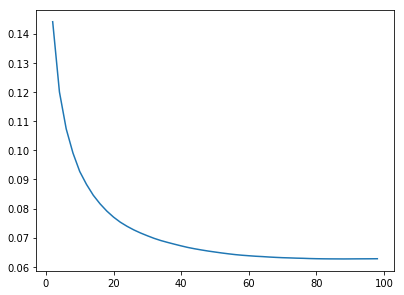

In [17]:
k_range, mcv_loss, rec_loss = mcv_pca(adata, recipe_sqrt, max_pcs=100)
plt.plot(k_range, mcv_loss)

Different normalization schemes do select different numbers of PCs.

Moreover, the sharpness/flatness of the basin does depend significantly on which recipe is used.

# Dependency on SNR

Downsample, and see how optimal number of PCs varies.

In [18]:
adata = load_pbmc()
adata.X = adata.X.astype(np.int)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.


In [19]:
ratio = np.arange(0.2, 1.2, 0.2)
total_counts = adata.X.sum()
mcv_losses = []

for r in ratio:
    adata_down = sc.pp.downsample_counts(adata, total_counts = int(r*total_counts), copy=True)
    k_range, mcv_loss, rec_loss = mcv_pca(adata_down, recipe_seurat)
    mcv_losses.append(mcv_loss)

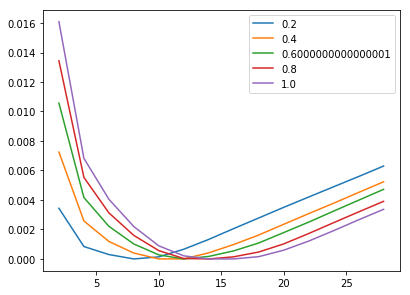

In [20]:
for i, r in enumerate(ratio):
    plt.plot(k_range, mcv_losses[i] - min(mcv_losses[i]), label=r)
plt.legend()

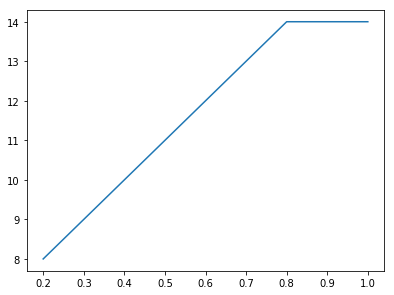

In [21]:
plt.plot(ratio, [k_range[np.argmin(mcv_loss)] for mcv_loss in mcv_losses])